In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# some parameters
binning = 250
smoothing = 5
exposure = 100

# info tables
infotable = '/data01/homes/dipiano/E4/irf_random/crab/sim/merged_simulator_data.dat'
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
60000,crab_00001,1,0,100,100,313.160025,23.341878,313.197506,22.894122,0.449081,North_z40_N_5h_LST,2.5,8.043759
60001,crab_00002,2,0,100,100,20.761826,-79.812129,30.555079,-80.334273,1.764702,North_z60_0.5h_LST,2.5,7.736644
60002,crab_00003,3,0,100,100,263.050678,-20.730728,263.711201,-21.511765,0.994811,North_z60_S_0.5h_LST,2.5,7.631279
60003,crab_00004,4,0,100,100,28.792668,-35.000006,28.821520,-35.011190,0.026146,North_z60_S_0.5h_LST,2.5,7.664158
60004,crab_00005,5,0,100,100,37.429610,-41.740501,38.148164,-41.630777,0.547721,North_z60_S_0.5h_LST,2.5,7.609625


In [2]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import wcs
from astroai.tools.utils import *

configuration = '/data01/homes/dipiano/astroAI/astroai/conf/regressor.yml'
conf = load_yaml_conf(configuration)
conf = conf['preprocess']
trange = [conf['time_start'], conf['time_stop']]
conf

{'directory': '/data01/homes/dipiano/E4/irf_random/crab/sim',
 'infotable': 'merged_simulator_data.dat',
 'sample': 5000,
 'time_start': 0,
 'time_stop': 100,
 'binning': 250,
 'smoothing': 5,
 'mode': 'localise',
 'norm_single_map': True,
 'norm_value': None,
 'stretch': False,
 'suffix': 'nonorm'}

In [3]:
f = '/data01/homes/dipiano/E4/irf_random/crab/sim/crab_03532.fits'
m = '/data01/homes/dipiano/E4/irf_random/crab/map_test_regressor/noisy/crab_03532_map.fits'
seed = int(''.join(filter(str.isdigit, basename(f))))
seed

3532

In [4]:
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
63531,crab_03532,3532,0,100,100,332.953012,59.696286,336.062743,59.921357,1.579804,North_z20_5h_LST,2.5,7.874264


# Check DL3 

In [5]:
from astropy.io import fits

# check from DL3
with fits.open(f) as h:
    hdr = h[1].header
    data = h[1].data
hdr['RA_PNT'], hdr['DEC_PNT'], hdr

(336.06274304,
 59.921356782,
 XTENSION= 'BINTABLE'           / binary table extension                         
 BITPIX  =                    8 / 8-bit bytes                                    
 NAXIS   =                    2 / 2-dimensional binary table                     
 NAXIS1  =                   36 / width of table in bytes                        
 NAXIS2  =                 5438 / number of rows in table                        
 PCOUNT  =                    0 / size of special data area                      
 GCOUNT  =                    1 / one data group (required keyword)              
 TFIELDS =                    8 / number of table fields                         
 TTYPE1  = 'EVENT_ID'           / label for field   1                            
 TFORM1  = '1J      '           / data format of field 1                         
 TZERO1  =           2147483648 / offset for unsigned integers                   
 TSCAL1  =                    1 / data are not scaled               

# Set WCS from DL4

In [22]:
# check from DL4
with fits.open(m) as h:
    hdr = h[0].header
    data = h[0].data
    wcs_skymap = WCS(h[0].header)
wcs_skymap, hdr, data.shape

(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---CAR'  'DEC--CAR'  
 CRVAL : 336.06274304  59.921356782  
 CRPIX : 125.5  125.5  
 NAXIS : 250  250,
 SIMPLE  =                    T / file does conform to FITS standard             
 BITPIX  =                  -64 / number of bits per data pixel                  
 NAXIS   =                    2 / number of data axes                            
 NAXIS1  =                  250 / length of data axis 1                          
 NAXIS2  =                  250 / length of data axis 2                          
 EXTEND  =                    T / FITS dataset may contain extensions            
 COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
 COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
 EXTNAME = 'SKYMAP  '           / name of this extension                         
 CRPIX1  =     1.2550000000E+02 / Pixel coordinate of reference point (starting f
 CRPIX2  =     1.255000000

In [21]:
# LABEL: convert source to pixel coordinates
xdl4, ydl4 = wcs_fits.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0],
                                        unit='deg', frame='icrs'))
xdl4, ydl4

(array(281.35533367), array(105.67686435))

# Set WCS with center = pointing

In [7]:
# set wcs
wcs_fits = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0],
                   point_ref=binning/2+0.5, pixelsize=row['fov'].values[0]/binning)
wcs_fits

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---CAR'  'DEC--CAR'  
CRVAL : 336.06274303675144  59.92135678230383  
CRPIX : 125.5  125.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.01  0.01  
NAXIS : 0  0

In [8]:
# LABEL: convert source to pixel coordinates
xfits, yfits = wcs_fits.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0],
                                        unit='deg', frame='icrs'))
xfits, yfits

(array(281.35533367), array(105.67686435))

# Set WCS with center = (0,0) of matrix

In [9]:
# set wcs
wcs_npy = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0],
                  point_ref=0, pixelsize=row['fov'].values[0]/binning)
# LABEL: convert source to pixel coordinates
xnpy, ynpy = wcs_npy.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0],
                                       unit='deg', frame='icrs'))
xnpy, ynpy

(array(155.85533367), array(-19.82313565))

In [10]:
sky_fits = wcs_fits.pixel_to_world(xfits, yfits)
sky_npy = wcs_npy.pixel_to_world(xnpy, ynpy)
print('TRUE coordinates sim:    ', row['source_ra'].values[0], row['source_dec'].values[0])
print('FITS WCS on NPY heatmap: ', sky_fits.ra.deg, sky_fits.dec.deg)
print('NPY WCS on NPY heatmap:  ', sky_npy.ra.deg, sky_npy.dec.deg)

TRUE coordinates sim:     332.9530120265075 59.696286387832345
FITS WCS on NPY heatmap:  332.9530120265075 59.696286387832345
NPY WCS on NPY heatmap:   332.9530120265075 59.696286387832345


# Verify WCS in plots

In [11]:
dl3 = Table.read(f, hdu=1).to_pandas()
heatmap, xe, ye = extract_heatmap_from_table(dl3, smoothing, binning, filter=True, trange=(0, exposure))
heatmap.shape, heatmap.max(), heatmap.min()

((250, 250), 0.4046109049920168, 0.0)

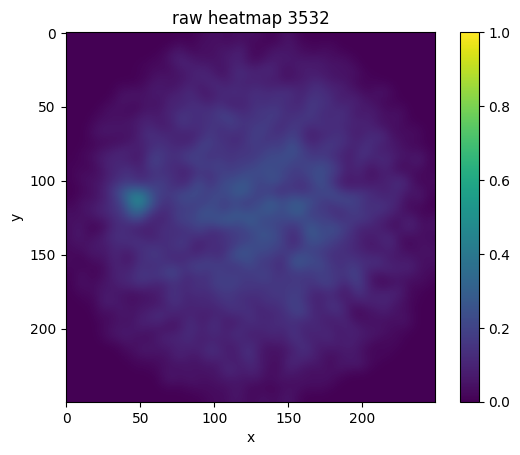

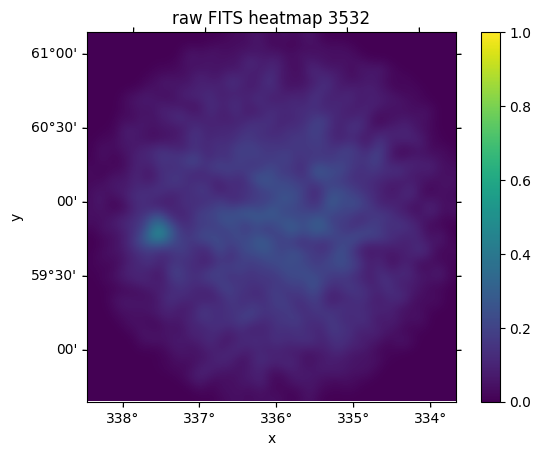

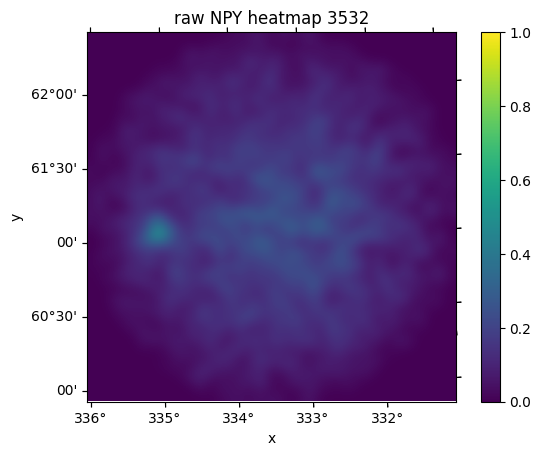

In [12]:
src_fits = (xfits, yfits)
src_npy = (xnpy, ynpy)

plot_heatmap_wcs(heatmap, title=f'raw heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=None, src=None, pnt=None)

plot_heatmap_wcs(heatmap, title=f'raw FITS heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_fits, src=None, pnt=None)

plot_heatmap_wcs(heatmap, title=f'raw NPY heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_npy, src=None, pnt=None)

# Stretch and normalise heatmap

In [12]:
stretch_heatmap = stretch_smooth(heatmap, smoothing)

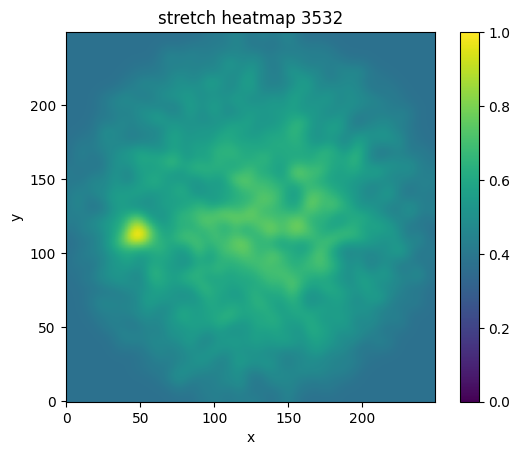

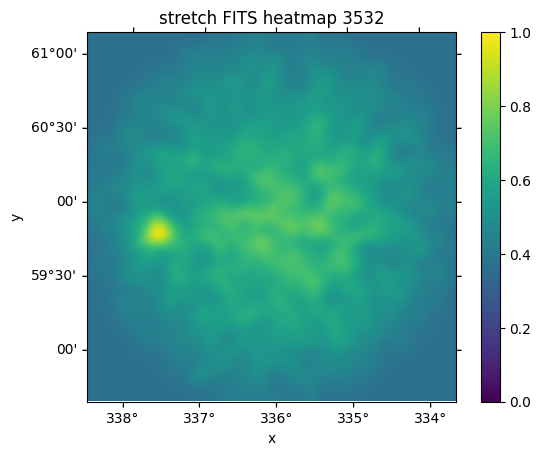

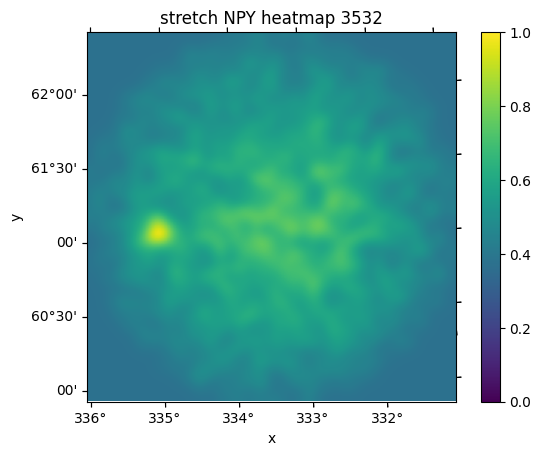

In [13]:
plot_heatmap_wcs(stretch_heatmap, title=f'stretch heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=None, src=None, pnt=None)

plot_heatmap_wcs(stretch_heatmap, title=f'stretch FITS heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_fits, src=None, pnt=None)

plot_heatmap_wcs(stretch_heatmap, title=f'stretch NPY heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_npy, src=None, pnt=None)

# Normalise heatmap

In [14]:
normed_heatmap = normalise_heatmap(heatmap)

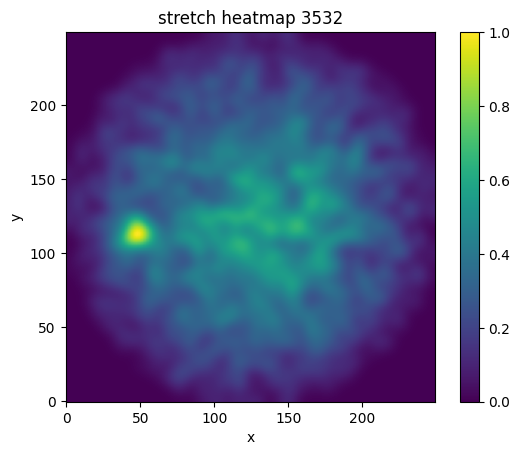

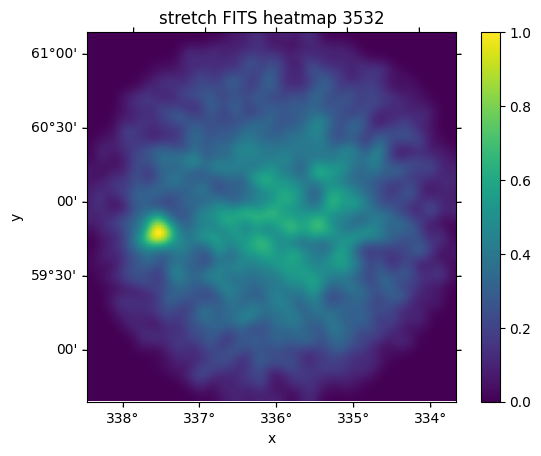

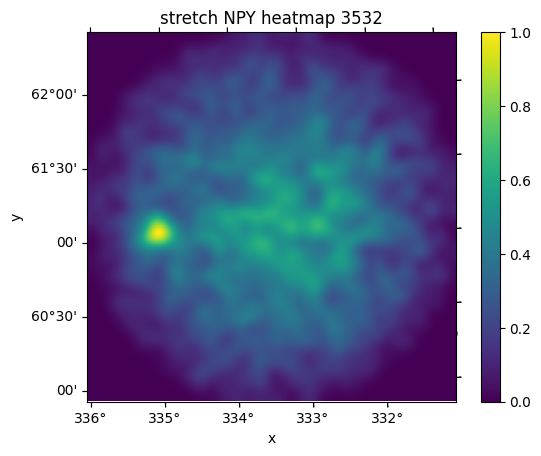

In [15]:
plot_heatmap_wcs(normed_heatmap, title=f'stretch heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=None, src=None, pnt=None)

plot_heatmap_wcs(normed_heatmap, title=f'stretch FITS heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_fits, src=None, pnt=None)

plot_heatmap_wcs(normed_heatmap, title=f'stretch NPY heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_npy, src=None, pnt=None)

# Normalise DS

In [16]:
norm_value = 0.5
ds_normed_heatmap = normalise_dataset(heatmap, max_value=norm_value)

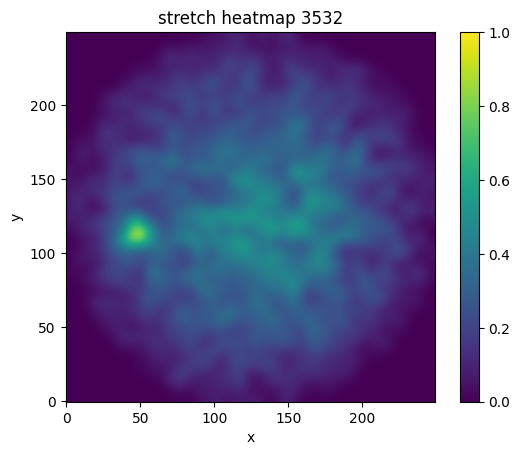

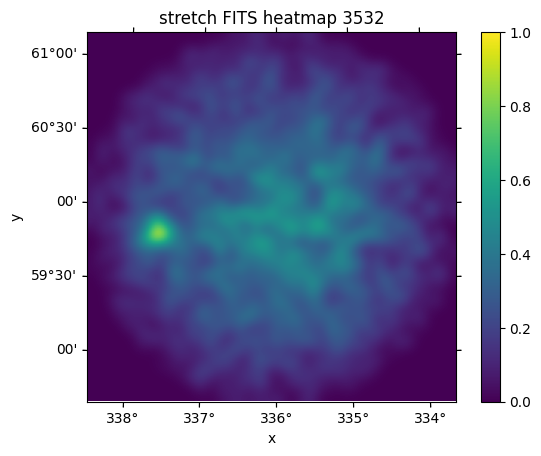

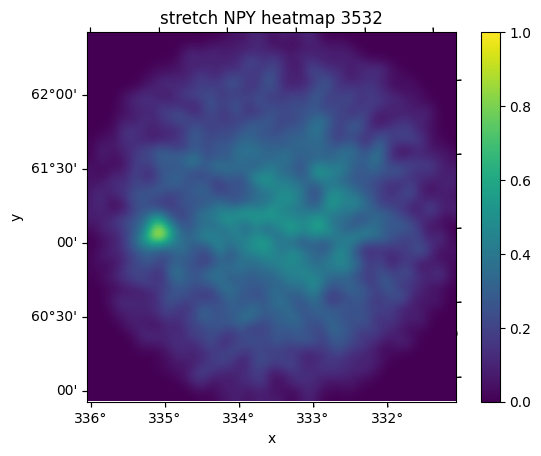

In [17]:
plot_heatmap_wcs(ds_normed_heatmap, title=f'stretch heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=None, src=None, pnt=None)

plot_heatmap_wcs(ds_normed_heatmap, title=f'stretch FITS heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_fits, src=None, pnt=None)

plot_heatmap_wcs(ds_normed_heatmap, title=f'stretch NPY heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_npy, src=None, pnt=None)

# Stretch and normalise DS

In [18]:
ds_stretch_heatmap = stretch_min_max(heatmap, vmax=norm_value)

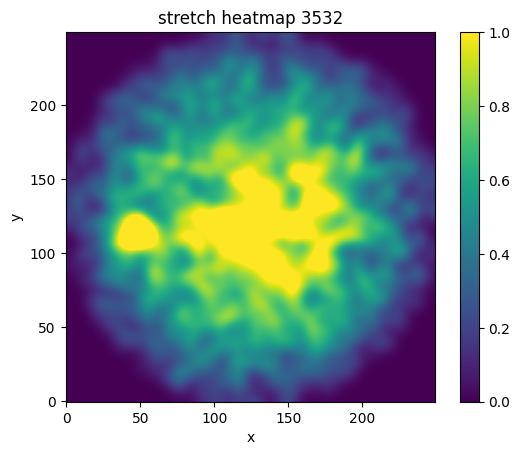

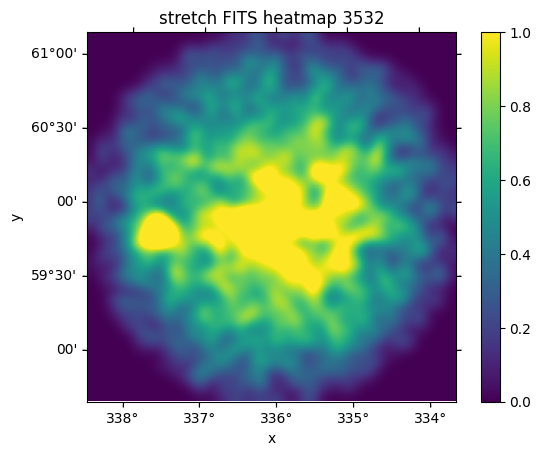

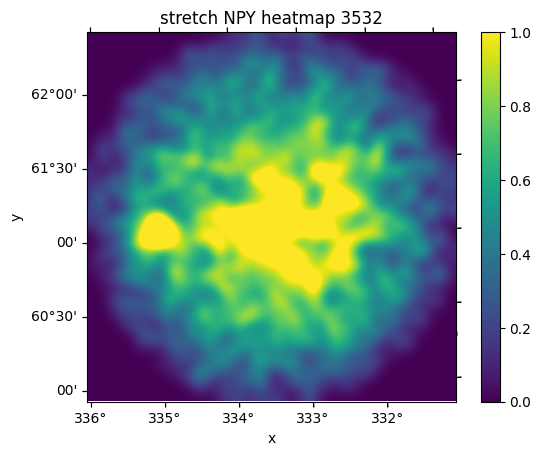

In [19]:
plot_heatmap_wcs(ds_stretch_heatmap, title=f'stretch heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=None, src=None, pnt=None)

plot_heatmap_wcs(ds_stretch_heatmap, title=f'stretch FITS heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_fits, src=None, pnt=None)

plot_heatmap_wcs(ds_stretch_heatmap, title=f'stretch NPY heatmap {seed}', xlabel='x', ylabel='y',
                 show=True, wcs=wcs_npy, src=None, pnt=None)